In [80]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

import utils
import methodprops
import plot_functions as fplot

import dsc
from dsc.query_engine import Query_Processor as dscQP
from dsc import dsc_io

import methodprops
plotmeta = methodprops.plot_metainfo()

In [3]:
resdir = "../dsc/results/"
plotdir = "boxplot_vs_cavi"

tf_pkl = os.path.join(resdir, "trendfiltering.pkl")

tf_df = pd.read_pickle(tf_pkl)
tf_df_order0 = tf_df[tf_df['simulate.dtrue'] == 0]
tf_df_order1 = tf_df[tf_df['simulate.dtrue'] == 1]

primary_keys = ['simulate', 'simulate.n', 'simulate.sfix', 'simulate.snr', 'simulate.dtrue']
secondary_keys = ['DSC']
unique_keys = ['simulate.dtrue']

df = utils.pivot_simulation_stat(tf_df, 'tfmse',
        primary_keys = primary_keys,
        secondary_keys = secondary_keys,
        unique_keys = unique_keys)

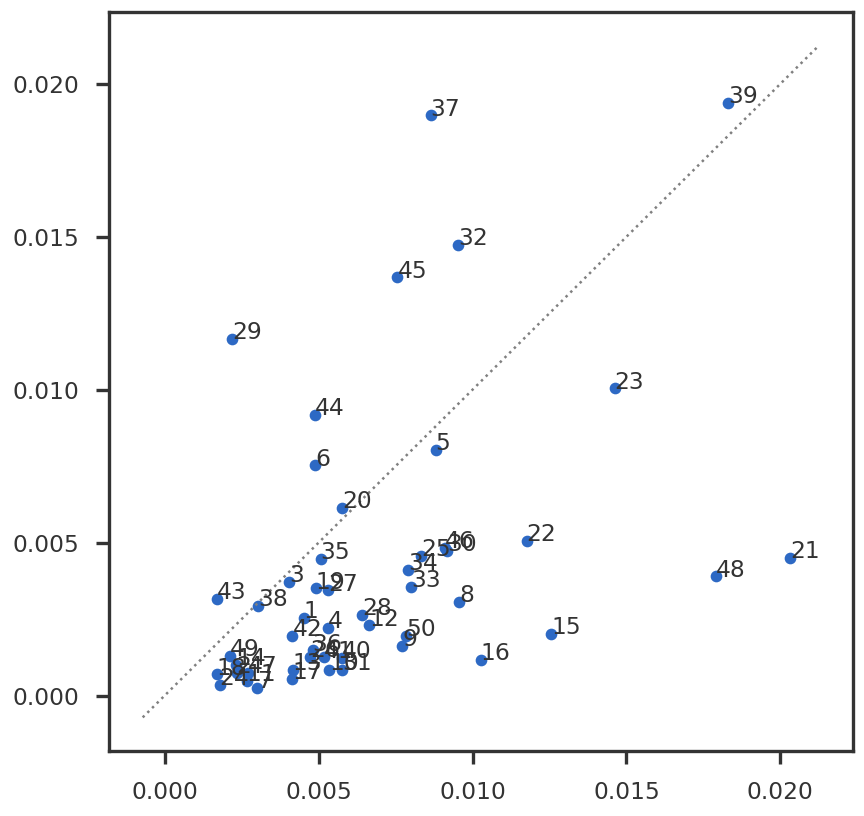

In [18]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

fig = plt.figure()
ax1 = fig.add_subplot(111)

method1 = 'mr_ash_init'
method2 = 'gradvi_compound_init'

ax1.scatter(df[method1], df[method2])

for k, v in df[[method1, method2]].iterrows():
    ax1.annotate(k, v)


mpl_utils.plot_diag(ax1)
plt.show()

In [22]:
idsc = 21

In [23]:
tf_df[tf_df['DSC'] == idsc]

,simulate,simulate.n,simulate.sfix,simulate.snr,simulate.dtrue,fit,DSC,tfmse,niter,elbo,elboR,runtime_wall,runtime_cpu,runtime_dsc,convergence
20,changepoint,4096,10,5,0,mr_ash_init,21,0.020323,2000,1167.618186,1167.618186,234.518000,232.399000,234.699000,3
70,changepoint,4096,10,5,0,mr_ash_scaled_init,21,0.024729,1708,1637.594883,1637.594883,187.671000,184.013000,187.849000,1
120,changepoint,4096,10,5,0,gradvi_direct_scaled_init,21,0.007885,2000,222.769093,1772.768331,189.581201,189.035435,199.713843,4
170,changepoint,4096,10,5,0,gradvi_compound_init,21,0.004495,1189,-541.855714,950.106890,486.627692,775.214114,513.620340,1
220,changepoint,4096,10,5,0,gradvi_compound_scaled_init,21,0.004716,2000,-215.354415,1340.177685,800.877443,1319.997777,826.927346,4


In [29]:
#dsc_output = "/gpfs/commons/groups/knowles_lab/sbanerjee/sparse-regression/gradvi-experiments/linreg_indep"
#dsc_output = "/gpfs/commons/groups/knowles_lab/sbanerjee/sparse-regression/gradvi-experiments/linreg_blockdiag"
dsc_output = "/gpfs/commons/groups/knowles_lab/sbanerjee/sparse-regression/gradvi-experiments/trendfiltering"

dsc_fname  = os.path.basename(os.path.normpath(dsc_output))
db = os.path.join(dsc_output, dsc_fname + ".db")
is_trendfiltering = True

if is_trendfiltering:
    target = ["simulate", "simulate.sfix", "simulate.snr", "simulate.n", "simulate.dtrue", "fit"]
else:
    target = ["simulate", "simulate.sfix", "simulate.pve",   "simulate.se", "simulate.dims", "fit"]

#condition = ["simulate.sfix == 2", "simulate.signal == 'normal'", "simulate.dims == '(50, 200)'"]
#groups = ["fit_cpt:"]
condition = [""]

print ("Reading from DSC database:")
print (f"    {db}")
print ("")

qp = dscQP(db, target, condition)
qpdf = qp.output_table
qpdf = qpdf[qpdf['DSC'] == idsc]

Reading from DSC database:
    /gpfs/commons/groups/knowles_lab/sbanerjee/sparse-regression/gradvi-experiments/trendfiltering/trendfiltering.db



In [30]:
qpdf

,DSC,simulate,simulate.snr,simulate.sfix,simulate.output.file,simulate.n,simulate.dtrue,fit,fit.output.file
20,21,changepoint,5,10,changepoint/changepoint_21,4096,0,mr_ash_init,mr_ash_init/changepoint_21_gvma_1_mr_ash_init_1
70,21,changepoint,5,10,changepoint/changepoint_21,4096,0,mr_ash_scaled_init,mr_ash_scaled_init/changepoint_21_gvma_1_mr_as...
120,21,changepoint,5,10,changepoint/changepoint_21,4096,0,gradvi_direct_scaled_init,gradvi_direct_scaled_init/changepoint_21_gvma_...
170,21,changepoint,5,10,changepoint/changepoint_21,4096,0,gradvi_compound_init,gradvi_compound_init/changepoint_21_gvma_1_gra...
220,21,changepoint,5,10,changepoint/changepoint_21,4096,0,gradvi_compound_scaled_init,gradvi_compound_scaled_init/changepoint_21_gvm...


In [32]:
utils.stratify_dfcol(qpdf, 'fit', 'mr_ash_init')

,DSC,simulate,simulate.snr,simulate.sfix,simulate.output.file,simulate.n,simulate.dtrue,fit,fit.output.file
20,21,changepoint,5,10,changepoint/changepoint_21,4096,0,mr_ash_init,mr_ash_init/changepoint_21_gvma_1_mr_ash_init_1


In [74]:
def get_output_filename_from_db(outdir, row):
    method = row['fit'].values[0]
    fprefix = row['fit.output.file'].values[0]
    ext = 'pkl' if method.startswith('gradvi') else 'rds'
    fname = os.path.join(outdir, f"{fprefix}.{ext}")
    return fname

def read_output_file(outdir, db, method):
    dfrow = utils.stratify_dfcol(db, 'fit', method)
    '''
    must be a single row after selection
    '''
    assert(dfrow.shape[0] == 1)
    fname = get_output_filename_from_db(outdir, dfrow)
    data  = dsc_io.load_dsc(fname)
    return data

def get_elbo_path(data):
    if 'fit' in data['model'].keys():
        return data['model']['fit']['varobj']
    else:
        return data['model']['elbo_path']

In [75]:
fname = os.path.join(dsc_output, f"{qpdf.iloc[0,]['simulate.output.file']}.pkl")
simdata = dsc_io.load_dsc(fname)

targets = ['mr_ash_init', 'mr_ash_scaled_init', 'gradvi_compound_init', 
           'gradvi_compound_scaled_init', 'gradvi_direct_scaled_init']

elbo_path = dict()
ypred = dict()
for method in targets:
    data = read_output_file(dsc_output, qpdf, method)
    ypred[method] = data['ypred']
    elbo_path[method] = get_elbo_path(data)

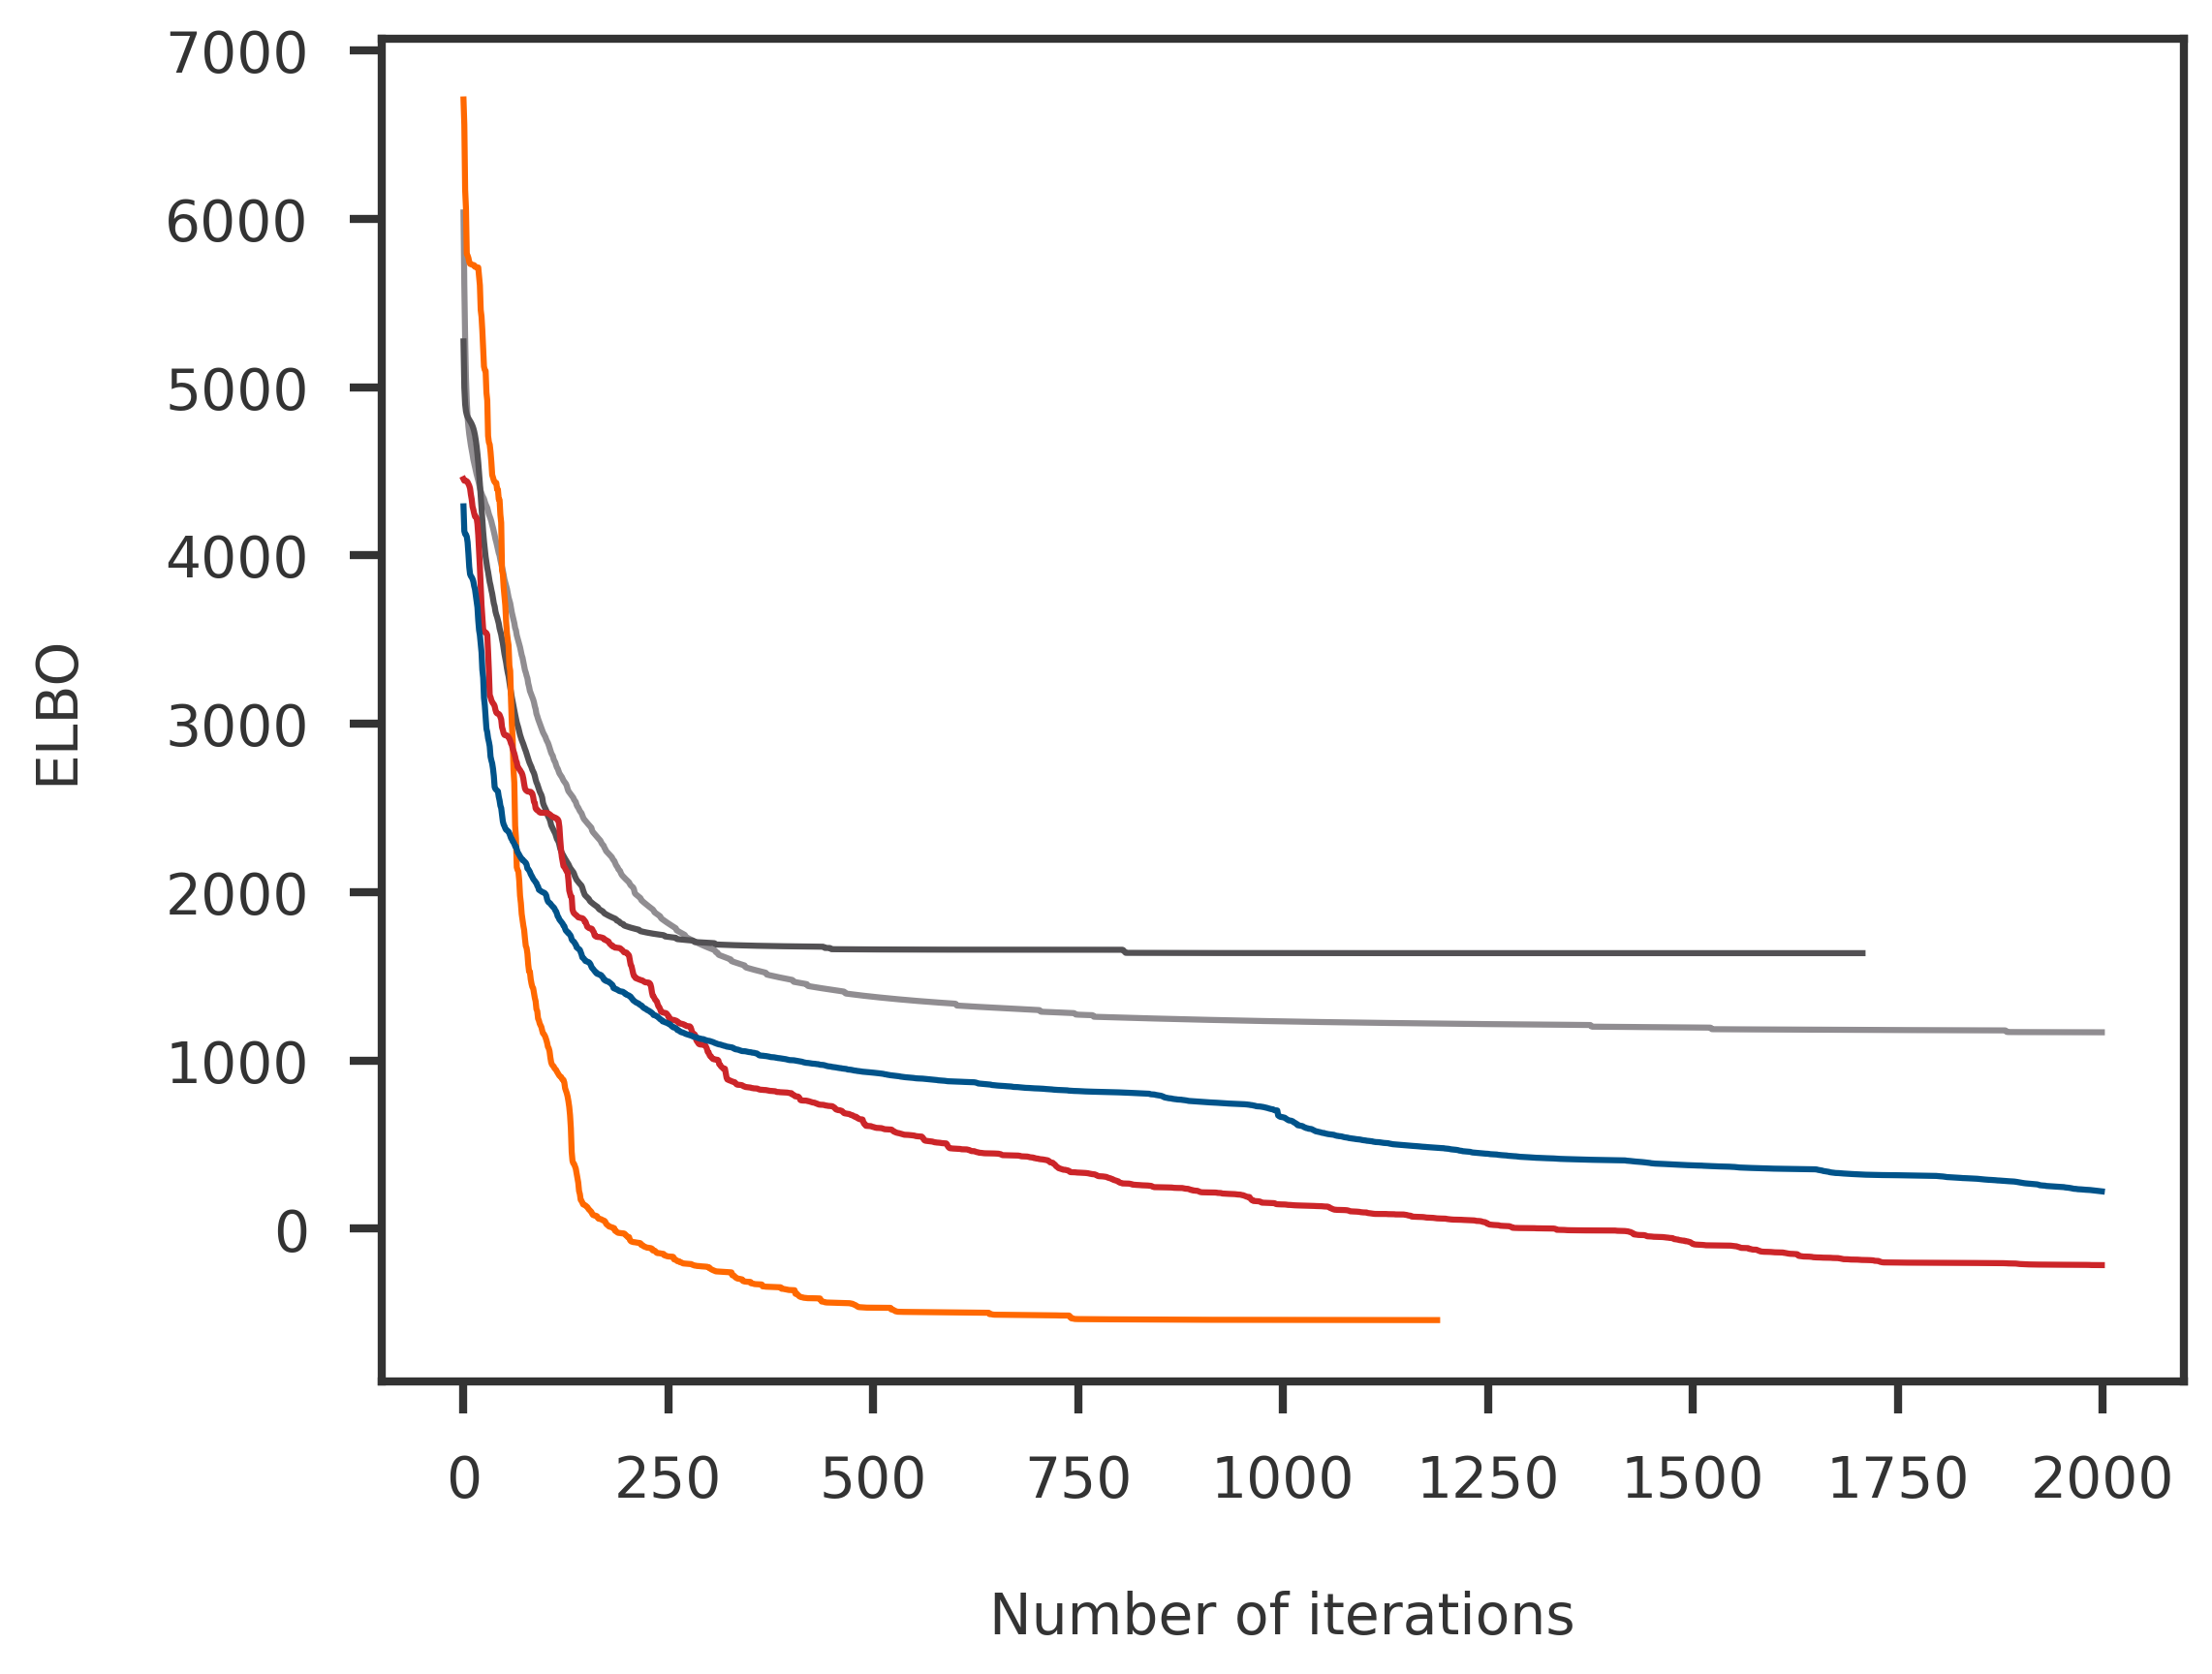

In [85]:
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 300)

fig = plt.figure(figsize = (8, 6))
ax1 = fig.add_subplot(111)

for method in targets:
    ev = elbo_path[method]
    #evdiff = ev[:-1] - ev[-1]
    #evdiff[evdiff == 0] = np.min(evdiff[evdiff != 0])
    #logev = np.log10(evdiff)
    #ax1.plot(np.arange(logev.shape[0]), logev, color = plotmeta[method].color)
    ax1.plot(np.arange(ev.shape[0]), ev, color = plotmeta[method].color)
    
ax1.set_xlabel("Number of iterations")
ax1.set_ylabel("ELBO")

utils.saveplot(fig, f"trendfiltering_elbo_example")

plt.show()